In [ ]:
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import importlib
import src.ensemble_trainer.ensemble_trainer
importlib.reload(src.ensemble_trainer.ensemble_trainer)
from src.ensemble_trainer.ensemble_trainer import CNNEnsembleTrainer
from torchvision import transforms
import random
rnd = random.Random(42)

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/8m/6z48y8212x782rk9dpgmm9lm0000gn/T/ipykernel_77670/3973929362.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


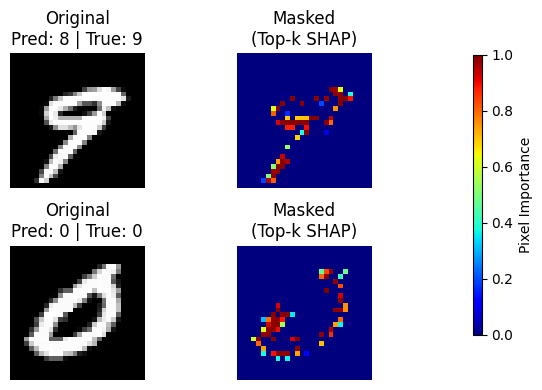

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6068112..1.0629398].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6068112..1.0629398].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9878542..2.0607288].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9878542..2.0607288].


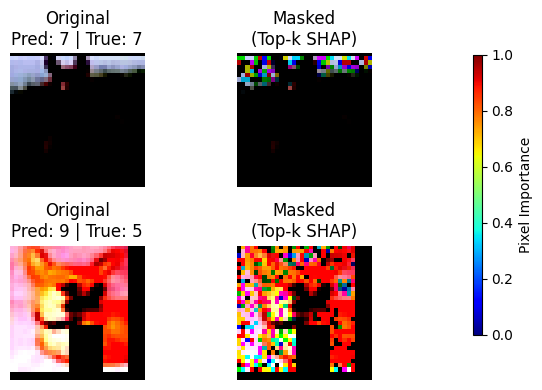

In [ ]:
def load_masked_original_data(shap_dir, percentile=90.0, batch_size=2):
    shap_files = sorted([f for f in os.listdir(shap_dir) if f.startswith("shap_batch")])
    image_files = sorted([f for f in os.listdir(shap_dir) if f.startswith("images_batch")])
    label_files = sorted([f for f in os.listdir(shap_dir) if f.startswith("labels_batch")])

    masked_all, original_all, labels_all = [], [], []

    for shap_f, img_f, lbl_f in zip(shap_files, image_files, label_files):
        shap_vals = torch.tensor(np.load(os.path.join(shap_dir, shap_f))).float()
        imgs = torch.tensor(np.load(os.path.join(shap_dir, img_f))).float()
        lbls = torch.tensor(np.load(os.path.join(shap_dir, lbl_f))).long()

        if shap_vals.shape != imgs.shape:
            shap_vals = F.interpolate(shap_vals, size=imgs.shape[2:], mode='bilinear', align_corners=False)

        threshold = torch.quantile(shap_vals.abs().flatten(1), percentile / 100.0, dim=1).view(-1, 1, 1, 1)
        mask = (shap_vals.abs() >= threshold).float()
        masked = imgs * mask

        original_all.append(imgs)
        masked_all.append(masked)
        labels_all.append(lbls)
    indices = []
    for b in range(batch_size):
        indices.append(rnd.randint(0, len(original_all) - 1))
    
    return (
        torch.cat(original_all)[indices],
        torch.cat(masked_all)[indices],
        torch.cat(labels_all)[indices]
    )

def load_model(model_path, model_id, dataset_name, config_path="../config/ensemble_config.yaml"):
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)

    trainer = CNNEnsembleTrainer(
        model_id=model_id,
        top_k_percentile=100,
        dataset_name=dataset_name,
        shap_dir="../shap_values/with_shap",
        masked_data=True,
        config_path='../config/ensemble_config.yaml',
        save_model_summary=False
    )
    
    model = trainer.model
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    
    model.eval()
    return model



def visualize_side_by_side(model, original_imgs, masked_imgs, labels, cmap_mask='hot'):
    import matplotlib.pyplot as plt

    device = next(model.parameters()).device
    original_imgs = original_imgs.to(device)

    with torch.no_grad():
        preds = torch.argmax(model(original_imgs), dim=1).cpu()

    batch_size = len(labels)
    fig, axes = plt.subplots(batch_size, 2, figsize=(8, batch_size * 2))

    for i in range(batch_size):
        for col in range(2):
            ax = axes[i, col] if batch_size > 1 else axes[col]
            if col == 0:
                img = original_imgs[i].cpu().squeeze()
                im = ax.imshow(img.numpy(), cmap='gray')
                ax.set_title(f"Original\nPred: {preds[i].item()} | True: {labels[i].item()}")
            else:
                img = masked_imgs[i].cpu().squeeze()
                im = ax.imshow(img.numpy(), cmap=cmap_mask)
                ax.set_title("Masked\n(Important Features)")
                # Add colorbar next to each masked image
                cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                cbar.set_label('Pixel Intensity')

            ax.axis('off')

    plt.tight_layout()
    plt.show()

def visualize_side_by_side(model, original_imgs, masked_imgs, labels, class_names=None, cmap_mask="jet"):
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    import matplotlib.cm as cm

    device = next(model.parameters()).device
    original_imgs = original_imgs.to(device)

    with torch.no_grad():
        preds = torch.argmax(model(original_imgs), dim=1).cpu()

    batch_size = len(labels)
    fig, axes = plt.subplots(batch_size, 2, figsize=(6, batch_size * 2))

    for i in range(batch_size):
        for col, img in enumerate([original_imgs[i].cpu(), masked_imgs[i]]):
            ax = axes[i, col] if batch_size > 1 else axes[col]
            img = img.permute(1, 2, 0).numpy()  # CHW → HWC
            if col == 0:
                ax.imshow(img, cmap='gray' if img.shape[-1] == 1 else None)
                ax.set_title(f"Original\nPred: {preds[i].item()} | True: {labels[i].item()}")
            else:
                norm = Normalize(vmin=0, vmax=1)
                ax.imshow(img, cmap=cmap_mask, norm=norm)
                ax.set_title("Masked\n(Top-k SHAP)")
            ax.axis('off')

    # Add legend colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    sm = cm.ScalarMappable(cmap=cmap_mask, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax, label='Pixel Importance')

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()


# --- RUN VISUALISATION ---
if __name__ == "__main__":

    for dataset in ['mnist', 'cifar10']:
        model_id = "MODEL151" if dataset == 'mnist' else "MODEL41"
        shap_dir = f"../shap_values/with_shap/{dataset}/test"
        model_path = f"../ensemble_models/with_shap/{dataset}/{model_id}_best_model.pt"
        
        dataset_name = dataset
        percentile = 90 if dataset == 'mnist' else 40
        original_imgs, masked_imgs, labels = load_masked_original_data(shap_dir, percentile=percentile)
        model = load_model(model_path, model_id, dataset_name)

        visualize_side_by_side(model, original_imgs, masked_imgs, labels)


